#MAKE SURE TO CREATE A FOLDER NAMED SNAPSHOTS

#importing libraries

In [ ]:
pip install selenium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.2/467.2 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.5 MB/s eta 0:00:00


In [ ]:
pip install openai==0.28

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.6 MB/s eta 0:00:00


In [ ]:
import folium
import random
import networkx as nx
from shapely.geometry import LineString, Polygon
import numpy as np
from queue import PriorityQueue
import time
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import cv2
import os
from selenium import webdriver
import re

#using coordinates for the region we are working on

In [ ]:
# Coordinates for the corners of the main square
corner1 = (33.257833, -97.178783)  # 33°15'40.2"N 97°10'43.7"W
corner2 = (33.257583, -97.090917)  # 33°15'39.3"N 97°05'27.3"W
corner3 = (33.184682, -97.090917)
corner4 = (33.184682, -97.178783)

# Define latitude and longitude ranges based on the corners of the main square
min_lat = min(corner1[0], corner2[0], corner3[0], corner4[0])
max_lat = max(corner1[0], corner2[0], corner3[0], corner4[0])
min_lon = min(corner1[1], corner2[1], corner3[1], corner4[1])
max_lon = max(corner1[1], corner2[1], corner3[1], corner4[1])

#creating the map

In [ ]:
# Create a map centered around Denton
denton_map = folium.Map(location=[33.2148, -97.1331], zoom_start=12)

# Define the coordinates for the main square
main_square_coordinates = [corner1, corner2, corner3, corner4]

# Create a polygon using the main square coordinates
main_square = Polygon(main_square_coordinates)



#finding drones with low battery

In [ ]:
def find_low_battery_drones(drones):
    """
    Checks the battery levels of all drones and returns the names of drones with less than 40% battery.

    Args:
        drones (list of dict): A list of dictionaries, where each dictionary contains 'name' and 'battery' keys.

    Returns:
        list of str: Names of drones with less than 40% battery.
    """
    low_battery_drones = [drone['name'] for drone in drones if drone['battery'] < 40]
    return low_battery_drones

#lat and lon to grid coordinates

In [ ]:
def lat_lon_to_grid(lat, lon):
    """
    Convert latitude and longitude to grid coordinates.

    Args:
        lat (float): Latitude.
        lon (float): Longitude.

    Returns:
        tuple: A tuple of grid coordinates (x, y).
    """
    grid_x = int((lat - min_lat) / (max_lat - min_lat) * grid_size)
    grid_y = int((lon - min_lon) / (max_lon - min_lon) * grid_size)
    return (grid_x, grid_y)

#finding nearest store

In [ ]:
def find_nearest_store(end_cell, store_locations):
      # Calculate distances between end_cell and each store location
      distances = [euclidean(end_cell, store) for store in store_locations]

      # Find the index of the nearest store
      nearest_store_index = np.argmin(distances)

      # Return the coordinates of the nearest store
      return store_locations[nearest_store_index]

#finding nearest charging station to recharge

In [ ]:
def find_nearest_station(drone_location, station_locations):
    """
    Finds the nearest charging station to a given drone location on the grid using Euclidean distance.

    Args:
        drone_location (tuple): The drone's current grid coordinates (x, y).
        station_locations (list of dicts): List of dictionaries containing station types and locations.

    Returns:
        tuple: The grid coordinates of the nearest charging station.
    """
    # Convert all station locations from lat/lon to grid coordinates
    grid_station_locations = [lat_lon_to_grid(station['location'][0], station['location'][1]) for station in station_locations]

    # Calculate distances using grid coordinates
    distances = [np.linalg.norm(np.array(drone_location) - np.array(loc)) for loc in grid_station_locations]

    # Find the index of the nearest station
    nearest_station_index = np.argmin(distances)

    # Return the grid coordinates of the nearest station
    return grid_station_locations[nearest_station_index]

#drone charging simulation

In [ ]:
def simulate_drone_movement(drone, station_locations):
    """
    Simulates moving a drone to the nearest charging station and back.

    Args:
        drone (dict): Drone information, including grid coordinates.
        station_locations (list of tuples): Latitudes and longitudes of charging stations.
    """
    with open('print_outputs.txt', 'w') as f:
      original_location = drone['location']  # Assume these are already grid coordinates
      f.write(f"{drone['name']} at grid location {original_location}. Searching for nearest charging station...\n")

      nearest_station = find_nearest_station(original_location, station_locations)

      f.write(f"{drone['name']} moving to nearest charging station at grid location {nearest_station}.\n")
      drone['location'] = nearest_station
      time.sleep(1)  # Simulate travel time

      f.write(f"{drone['name']} charging at the station...\n")
      x = drone['battery']
      drone['battery'] = 100
      f.write(f"battery charged: {100-x}'%\n")
      time.sleep(1)  # Simulate charging time
      drone['status'] = 'active'

      f.write(f"{drone['name']} returning to original location at grid location {original_location}.\n")
      drone['location'] = original_location
      time.sleep(1)  # Simulate return time

      f.write(f"{drone['name']} is back at location and fully charged.\n")

#euclidean distance between a and b

In [ ]:
def heuristic(a, b):
    """Calculate the Manhattan distance between two points, adjusted for diagonal movement"""
    dx = abs(b[0] - a[0])
    dy = abs(b[1] - a[1])
    return dx + dy - min(dx, dy)

#A* algorithm for least cost with diagonals

In [ ]:
def least_cost_path_with_diagonals_and_cost(grid, start, end):
    """Perform A* search to find the least cost path in a grid, including diagonal movement, and return the path and its total cost"""
    neighbors = [(0, 1), (1, 0), (0, -1), (-1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1)]
    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: heuristic(start, end)}
    oheap = PriorityQueue()
    oheap.put((fscore[start], start))

    while not oheap.empty():
        current = oheap.get()[1]

        if current == end:
            path = []
            total_cost = 0
            while current in came_from:
                path.append(current)
                current = came_from[current]
                if path:
                    total_cost += grid[path[-1][0]][path[-1][1]]
            path.reverse()
            path.insert(0, start)
            # Add the start cell cost since it's not included in the loop
            total_cost += grid[start[0]][start[1]]
            return path, total_cost

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j
            if 0 <= neighbor[0] < grid.shape[0] and 0 <= neighbor[1] < grid.shape[1]:
                if i == 0 or j == 0:
                    # Horizontal or vertical movement
                    movement_cost = grid[neighbor[0]][neighbor[1]]
                else:
                    # Diagonal movement
                    movement_cost = grid[neighbor[0]][neighbor[1]] + 1

                tentative_g_score = gscore[current] + movement_cost

                if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                    continue

                if tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1] for i in oheap.queue]:
                    came_from[neighbor] = current
                    gscore[neighbor] = tentative_g_score
                    fscore[neighbor] = tentative_g_score + heuristic(neighbor, end)
                    oheap.put((fscore[neighbor], neighbor))

    return None

#MAP GENERATION

In [ ]:
import folium
import random

# Define the grid size
grid_size = 50

# Define the number of each type of cell
num_stores = 20
num_customers = 100
num_nfzs = 300
num_stations = 10

# Create a Folium map object centered on the main square
denton_map = folium.Map(location=[(max_lat + min_lat) / 2, (max_lon + min_lon) / 2], zoom_start=14)

# Calculate the step size for each grid cell
lat_step = (max_lat - min_lat) / grid_size
lon_step = (max_lon - min_lon) / grid_size

# Draw the grid on the map by adding lines
for i in range(grid_size + 1):
    folium.PolyLine([(min_lat + i * lat_step, min_lon), (min_lat + i * lat_step, max_lon)], color='grey', weight=1).add_to(denton_map)
    folium.PolyLine([(min_lat, min_lon + i * lon_step), (max_lat, min_lon + i * lon_step)], color='grey', weight=1).add_to(denton_map)

# Initialize the grid with +1 for all cells
grid = [[1 for _ in range(grid_size)] for _ in range(grid_size)]

# Generate all possible grid cell center points
all_grid_cells = [(min_lat + i * lat_step + lat_step / 2, min_lon + j * lon_step + lon_step / 2)
                  for i in range(grid_size) for j in range(grid_size)]

# Shuffle the list of grid cells and then take the first N cells for each type
random.shuffle(all_grid_cells)
store_cells = all_grid_cells[:num_stores]
customer_cells = all_grid_cells[num_stores:num_stores+num_customers]
nfz_cells = all_grid_cells[num_stores+num_customers:num_stores+num_customers+num_nfzs]
station_cells = all_grid_cells[num_stores+num_customers+num_nfzs:num_stores+num_customers+num_nfzs+num_stations]

# Convert grid indices back to latitude and longitude (placeholders for actual conversion)
store_locations = [{'type': 'store', 'location': (index[0], index[1])} for index in store_cells]
customer_locations = [{'type': 'customer', 'location': (index[0], index[1])} for index in customer_cells]
station_locations = [{'type': 'station', 'location': (index[0], index[1])} for index in station_cells]

# Initialize the grid with 'o' for all cells
char_grid = [['.' for _ in range(grid_size)] for _ in range(grid_size)]

# Update the char_grid with 's' for store cells
for cell in store_cells:
    i = int((cell[0] - min_lat) / lat_step)
    j = int((cell[1] - min_lon) / lon_step)
    char_grid[i][j] = 's'

# Update the char_grid with 'c' for customer cells
for cell in customer_cells:
    i = int((cell[0] - min_lat) / lat_step)
    j = int((cell[1] - min_lon) / lon_step)
    char_grid[i][j] = 'c'

for cell in station_cells:
    i = int((cell[0] - min_lat) / lat_step)
    j = int((cell[1] - min_lon) / lon_step)
    char_grid[i][j] = 'st'

# Print or use the char_grid as needed
for row in char_grid:
    print(' '.join(row))

# Update the grid with +10 for no-fly zones
for cell in nfz_cells:
    i = int((cell[0] - min_lat) / lat_step)
    j = int((cell[1] - min_lon) / lon_step)
    grid[i][j] = 10

# Place the stores, customers,stations and no-fly zones on the map
# Stores will be green markers
for cell in store_cells:
    folium.Marker(location=cell, icon=folium.Icon(color='green'), tooltip='Store').add_to(denton_map)

# Customers will be blue markers
for cell in customer_cells:
    folium.Marker(location=cell, icon=folium.Icon(color='blue'), tooltip='Customer').add_to(denton_map)

# Customers will be blue markers
for cell in station_cells:
    folium.Marker(location=cell, icon=folium.Icon(color='red'), tooltip='station').add_to(denton_map)


# No-fly zones will be red squares
for cell in nfz_cells:
    nfz_corner_lat = cell[0] - lat_step / 2
    nfz_corner_lon = cell[1] - lon_step / 2
    folium.Rectangle(
        bounds=[(nfz_corner_lat, nfz_corner_lon),
                (nfz_corner_lat + lat_step, nfz_corner_lon + lon_step)],
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.5
    ).add_to(denton_map)

# Save the map to an HTML file or display it
denton_map


. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . c . . . c . .
. . . . . c . . . . . . . . . . . . . . . . . . . . c . . . . . c . . . st . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . c . . . . . . . . . . . . c . . . . . . . . . . . . . . . . . .
. c . . c . . . . . . . . . . . . . . . . . . . . . . . . . . c . . . . . . . . . . . . . . . . c .
. . . . . . . . c . . . . . . . . c . . . . . . . . . . . . . . . c . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . c . . . . . . . . . . .
. . . . . . . . . c . . . . . . . . . . . s . . . . . . . . . c . c . . . . . . . . . c . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . s . c . . . . . . . . . . . . . . .
. . . . . . . c . . . . . . . . . . c . . . . . . . . . . . . . . . . . . . . . s . . c . . . . . .
. . . . c . . . . . . . . . . . . . . . . . . . . . . . . . . c . . . . . . . . . . . . . . . . . .

#DRONE INITIALIZATION

In [ ]:
# Initialize drones at store locations with grid coordinates
drones = []
for idx, cell in enumerate(store_cells):
    grid_i = int((cell[0] - min_lat) / lat_step)  # Row index in the grid
    grid_j = int((cell[1] - min_lon) / lon_step)  # Column index in the grid
    drones.append({
        'name': f'Drone_{idx + 1}',
        'location': (grid_i, grid_j),
        'battery': 100,  # Initial battery percentage
        'status' : 'active'
    })

# Print drone information using grid coordinates
for drone in drones:
    print(f"{drone['name']} : grid position {drone['location']} : {drone['battery']}% battery : status {drone['status']}")

Drone_1 : grid position (20, 34) : 100% battery : status active
Drone_2 : grid position (49, 38) : 100% battery : status active
Drone_3 : grid position (39, 15) : 100% battery : status active
Drone_4 : grid position (6, 21) : 100% battery : status active
Drone_5 : grid position (46, 45) : 100% battery : status active
Drone_6 : grid position (48, 21) : 100% battery : status active
Drone_7 : grid position (20, 19) : 100% battery : status active
Drone_8 : grid position (8, 40) : 100% battery : status active
Drone_9 : grid position (15, 38) : 100% battery : status active
Drone_10 : grid position (34, 2) : 100% battery : status active
Drone_11 : grid position (12, 36) : 100% battery : status active
Drone_12 : grid position (13, 19) : 100% battery : status active
Drone_13 : grid position (7, 32) : 100% battery : status active
Drone_14 : grid position (46, 2) : 100% battery : status active
Drone_15 : grid position (31, 11) : 100% battery : status active
Drone_16 : grid position (13, 4) : 100%

#initializing battery tracking dictionary

In [ ]:
# Battery tracking dictionary
battery_tracking = {drone['name']: [] for drone in drones}
profits = []

#DRONE SIMULATION

In [ ]:
with open('print_outputs.txt', 'w') as f:
  x = 0
  for i in range(70):
    # Randomly select start and end positions from 's' and 'c' cells
    start_cell = random.choice([(i, j) for i in range(grid_size) for j in range(grid_size) if char_grid[i][j] == 's'])
    end_cell = random.choice([(i, j) for i in range(grid_size) for j in range(grid_size) if char_grid[i][j] == 'c'])
    grid = np.array(grid)
    # Find least cost path including diagonal movement and calculate total cost
    path, total_cost = least_cost_path_with_diagonals_and_cost(grid, start_cell, end_cell)
    f.write(f"Start position: {start_cell}\n")
    f.write(f"End position: {end_cell}\n")
    f.write(f"Least cost path with diagonals: {path}\n")
    f.write(f"Total cost of the path: {total_cost}\n")
    profits.append(total_cost)
    # Update drone based on path cost
    for drone in drones:
        battery_tracking[drone['name']].append(drone['battery'])
        if drone['location'] == start_cell:
            drone['location'] = end_cell
            drone['battery'] -= total_cost /2
            battery_tracking[drone['name']].append(drone['battery'])
            break

    #CHANGING TO INACTIVE
    for drone in drones:
      if(drone['battery']<40):
        drone['status'] = 'inactive'
    for drone in drones:
      f.write(f"{drone}\n")

    # Calculate the latitude and longitude step size for each grid cell
    lat_step_size = (max_lat - min_lat) / grid_size
    lon_step_size = (max_lon - min_lon) / grid_size

    # Convert grid cell indices in the path to latitude and longitude coordinates
    path_coordinates = [(min_lat + cell[0] * lat_step_size + lat_step_size / 2,
                        min_lon + cell[1] * lon_step_size + lon_step_size / 2) for cell in path]

    # Draw the path on the map with tooltips and random color (excluding red)
    import random

    # Draw the path on the map with tooltips and random dark color (excluding red)
    for i in range(len(path_coordinates) - 1):
        start_point = path_coordinates[i]
        end_point = path_coordinates[i + 1]
        path_info = f"From: {start_point}\nTo: {end_point} ......Total Cost {total_cost}....Fuel Consumption : {total_cost/2}%"  # Customize the tooltip content as needed

        # Generate random dark RGB values for the color (excluding red)
        color = "#{:02x}{:02x}{:02x}".format(random.randint(0, 127), random.randint(0, 127), random.randint(0, 127))
        folium.PolyLine([start_point, end_point], color=color, weight=2, tooltip=path_info).add_to(denton_map)


    # Assuming you have the store locations stored in a list called 'store_locations'
    store_locations = [(i, j) for i in range(grid_size) for j in range(grid_size) if char_grid[i][j] == 's']

    # Example usage
    nearest_store = find_nearest_store(end_cell, store_locations)
    f.write(f"Nearest store from end position: {nearest_store}\n")
    path_return, total_cost = least_cost_path_with_diagonals_and_cost(grid, end_cell, nearest_store)
    f.write(f"Start position: {end_cell}\n")
    f.write(f"nearest_store position: {nearest_store}\n")
    f.write(f"Least cost path with diagonals: {path}\n")
    f.write(f"Total cost of the path: {total_cost}\n")
    profits.append(total_cost)
    for drone in drones:
        if drone['location'] == end_cell:
            drone['location'] = nearest_store
            drone['battery'] -= total_cost / 2
            break

    # Calculate the latitude and longitude step size for each grid cell
    lat_step_size = (max_lat - min_lat) / grid_size
    lon_step_size = (max_lon - min_lon) / grid_size

    # Convert grid cell indices in the path to latitude and longitude coordinates
    path_coordinates = [(min_lat + cell[0] * lat_step_size + lat_step_size / 2,
                        min_lon + cell[1] * lon_step_size + lon_step_size / 2) for cell in path_return]

    for drone in drones:
      if drone['battery'] < 40:
          f.write(f"{drone['name']}\n")
          simulate_drone_movement(drone, station_locations)

    # Draw the path on the map with tooltips
    for i in range(len(path_coordinates) - 1):
        start_point = path_coordinates[i]
        end_point = path_coordinates[i + 1]
        path_info = f"From: {start_point}\nTo: {end_point}"  # Customize the tooltip content as needed
        folium.PolyLine([start_point, end_point], color='red', weight=2, tooltip=path_info).add_to(denton_map)

    denton_map.save(f'snapshots/map_snapshot_{x}.html')
    x = x +1
print("Print outputs saved to 'print_outputs.txt'.")

Print outputs saved to 'print_outputs.txt'.


#profits in dollars at each drone scheduled

In [ ]:
profits

[37,
 6,
 22,
 10,
 21,
 6,
 29,
 2,
 6,
 3,
 11,
 5,
 29,
 6,
 19,
 2,
 25,
 6,
 17,
 13,
 42,
 6,
 2,
 2,
 28,
 6,
 43,
 2,
 27,
 4,
 31,
 11,
 36,
 2,
 16,
 2,
 37,
 6,
 14,
 5,
 35,
 11,
 16,
 2,
 18,
 5,
 7,
 6,
 29,
 8,
 21,
 11,
 7,
 7,
 15,
 6,
 25,
 4,
 9,
 8,
 37,
 2,
 33,
 5,
 36,
 4,
 31,
 4,
 47,
 9,
 17,
 9,
 31,
 2,
 5,
 4,
 14,
 6,
 15,
 9,
 16,
 6,
 26,
 5,
 18,
 4,
 21,
 6,
 16,
 6,
 17,
 7,
 12,
 5,
 28,
 13,
 47,
 5,
 25,
 4,
 20,
 3,
 45,
 9,
 24,
 5,
 13,
 6,
 21,
 2,
 35,
 4,
 21,
 3,
 26,
 3,
 42,
 9,
 42,
 3,
 16,
 8,
 24,
 8,
 26,
 8,
 45,
 6,
 26,
 4,
 33,
 13,
 13,
 5,
 18,
 5,
 43,
 2,
 34,
 6]

# KDE plot of profits

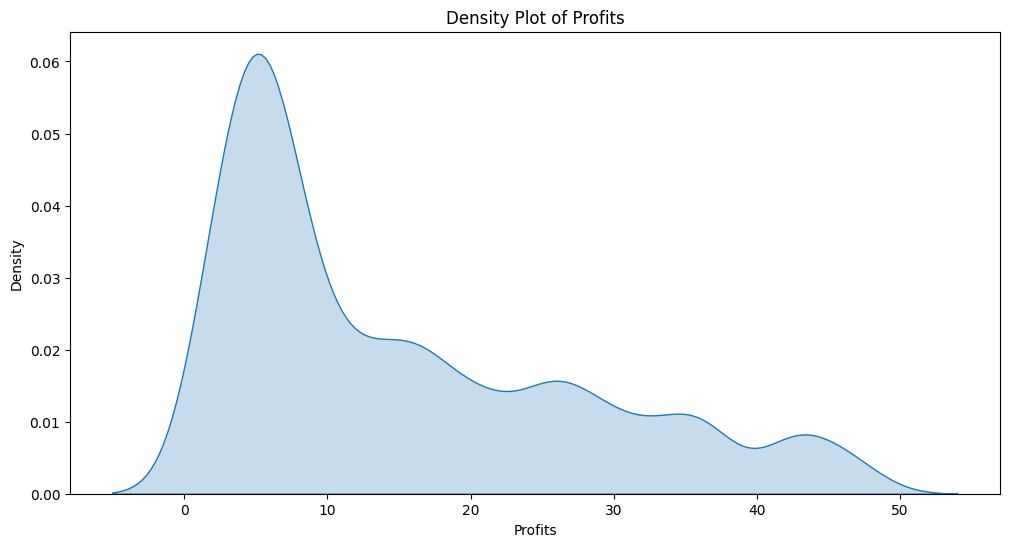

In [ ]:
import seaborn as sns

# Using Seaborn to plot a KDE plot
plt.figure(figsize=(12, 6))
sns.kdeplot(profits, bw_adjust=0.5, fill=True)  # 'bw_adjust' controls the smoothness of the curve
plt.title('Density Plot of Profits')
plt.xlabel('Profits')
plt.ylabel('Density')
plt.show()


In [ ]:
battery_tracking

{'Drone_1': [100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  84.5,
  79.0,
  79.0,
  79.0,
  79.0,
  72.0,
  69.5,
  69.5,
  69.5,
  60.5,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  58.0,
  47.5,
  46.5,
  46.5,
  46.5,
  33.5,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100],
 'Drone_2': [100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  86.5,
  84.5,
  84.5,
  84.5,
  84.5,
  84.5,
  76.5,
  75.5,
  75.5,
  75.5,
  75.5,
  75.5,
  75.5,
  63.0,
  61.0,
  61.0,
  61.0,
  61.0,
  61.0,
  61.0,
  61.0,
  61.0,
  61.0,
  61.0,
  61.0,
  61.0,
  61.0,
  61.0,
  61.0,
  61.0,
  61.0,
  61.0,
  61.0,
  61.0,
  61.0,
  61.0,
  61.0,
  61

#TIME SERIES PLOT OF EACH DRONES BATTERY VS ELAPSED TIME

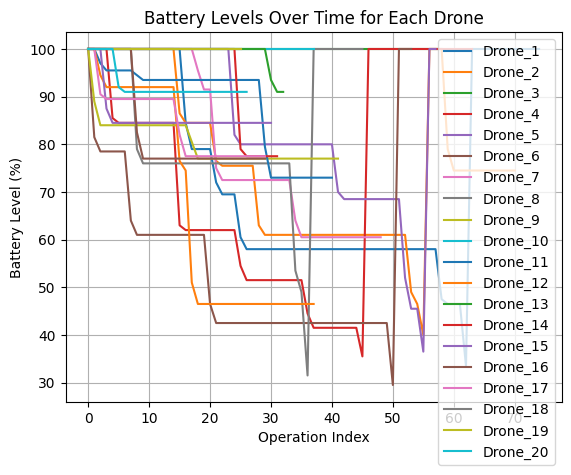

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'battery_tracking' is a dictionary with drone names as keys and lists of battery levels as values
for drone, batteries in battery_tracking.items():
    plt.plot(batteries, label=drone)

plt.title('Battery Levels Over Time for Each Drone')
plt.xlabel('Operation Index')
plt.ylabel('Battery Level (%)')
plt.legend()
plt.grid(True)
plt.show()


#HEATMAP OF BATTERY LEVELS

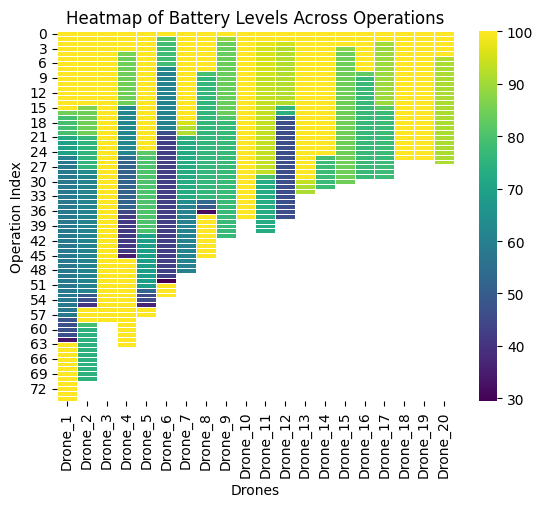

In [ ]:
import seaborn as sns
import pandas as pd

# Convert the battery_tracking dictionary into a DataFrame for easier plotting
df = pd.DataFrame.from_dict(battery_tracking, orient='index').transpose()
sns.heatmap(df, annot=False, cmap='viridis', linewidths=.5)
plt.title('Heatmap of Battery Levels Across Operations')
plt.xlabel('Drones')
plt.ylabel('Operation Index')
plt.show()


#FINAL MAP


In [ ]:
denton_map

#video creation

In [ ]:


# Path to the directory containing the HTML files
html_dir = "snapshots"

# Safely extract numbers from filenames and sort them
def safe_numerical_sort(file_name):
    match = re.search(r'\d+', file_name)
    if match:
        return int(match.group())
    return float('inf')  # Return infinity for filenames without numbers

# Get the list of HTML files
html_files = os.listdir(html_dir)
html_files_sorted = sorted(html_files, key=safe_numerical_sort)

if not html_files_sorted or html_files_sorted[0] == float('inf'):
    print("No appropriately named HTML files found in the directory.")
    exit()  # Exit if no HTML files match the expected naming pattern

# Define the dimensions of the browser window
browser_width = 1920
browser_height = 1080

# Calculate the new dimensions after zooming out by 10%
new_width = int(browser_width * 0.9)
new_height = int(browser_height * 0.9)

# Initialize the Chrome WebDriver
options = webdriver.ChromeOptions()
options.add_argument('--headless')  # Run Chrome in headless mode
options.add_argument('--disable-gpu')  # Disable GPU acceleration
options.add_argument('--no-sandbox')  # Disable sandbox mode
driver = webdriver.Chrome(options=options)
driver.set_window_size(new_width, new_height)

# Create a VideoWriter object
output_video_path = "output.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = 10  # Adjust the frames per second as needed
out = cv2.VideoWriter(output_video_path, fourcc, fps, (new_width, new_height))

# Iterate through each HTML file, render it in the browser, capture screenshot, and add it to the video
for html_file in html_files_sorted:
    html_path = os.path.join(html_dir, html_file)
    driver.get(f'file://{os.path.abspath(html_path)}')

    # Capture screenshot of the rendered HTML and convert it to a numpy array
    screenshot = driver.get_screenshot_as_png()
    nparr = np.frombuffer(screenshot, np.uint8)
    frame = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    # Add the frame to the video multiple times to increase the duration
    for _ in range(fps * 1):
        out.write(frame)

# Release the resources
out.release()
driver.quit()

print(f"Video saved as {output_video_path}")



Video saved as output.mp4


In [ ]:
import openai

def split_text(text, max_length=127000):
    """
    Splits the text into chunks that are smaller than the maximum length allowed by the API.

    Args:
        text (str): The text to be split.
        max_length (int): Maximum length of text for each split.

    Returns:
        list: A list of strings where each string is a segment of the original text.
    """
    words = text.split()
    segments = []
    current_segment = []

    for word in words:
        if len(' '.join(current_segment + [word])) > max_length:
            segments.append(' '.join(current_segment))
            current_segment = [word]
        else:
            current_segment.append(word)

    if current_segment:
        segments.append(' '.join(current_segment))

    return segments

def summarize_text(segments, api_key):
    """
    Summarizes each segment of text using OpenAI's GPT model.

    Args:
        segments (list): List of text segments to summarize.
        api_key (str): OpenAI API key for authentication.

    Returns:
        list: Summaries of each segment.
    """
    summaries = []
    engine = "gpt-4-turbo"  # Ensure this is the correct model

    openai.api_key = api_key

    for segment in segments:
        prompt = "Summarize the following text and give a table type data:\n" + segment
        try:
            response = openai.ChatCompletion.create(
                model=engine,
                messages=[
                    {"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": prompt}
                ]
            )
            summary = response['choices'][0]['message']['content'].strip()
            summaries.append(summary)
        except Exception as e:
            summaries.append(f"An error occurred: {str(e)}")
            continue

    return summaries

def main():
    file_path = 'print_outputs.txt'
    api_key = ''  # Place your API key here securely

    try:
        with open(file_path, 'r') as file:
            text = file.read()

        segments = split_text(text)
        summaries = summarize_text(segments, api_key)

        print("Generated Summaries:")
        for summary in summaries:
            print(summary)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' does not exist.")

if __name__ == "__main__":
    main()


Generated Summaries:
### Summary
Drone_5 was initially at grid location (13, 19) and needed to recharge. It moved to the nearest charging station located at (12, 18) to recharge its battery, which reached 66%. After charging, Drone_5 returned to its original location at (13, 19) and is now fully charged.

### Table of Drone_5's Activity
| Action                | Grid Location | Battery Status      |
|-----------------------|---------------|---------------------|
| Initial Position      | (13, 19)      | Not specified       |
| Move to Charging      | (12, 18)      | Moving              |
| Charging at Station   | (12, 18)      | Charged to 66.0%    |
| Return to Original    | (13, 19)      | Moving              |
| Back at Original      | (13, 19)      | Fully charged       |
An error occurred: This model's maximum context length is 128000 tokens. However, your messages resulted in 154341 tokens. Please reduce the length of the messages.
An error occurred: HTTP code 502 from API (<html